# Methods and Results 

In [34]:
## Required packages and versions
# install.packages("janitor")
# install.packages("cowplot")
# install.packages("GGally")
install.packages("plotly")

also installing the dependencies ‘lazyeval’, ‘crosstalk’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [35]:
library(tidyverse)
library(janitor)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)
library(plotly)


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




## Preliminary Exploratory Data Analysis

### 1. Load the Original Dataset 


Source: https://www.kaggle.com/datasets/risakashiwabara/jpmean-and-standard-deviation-of-height-and-weight/

To answer this question we will analyze a data set of Japanese boys' heights and weights. This data, `man.csv` was downloaded from [Kaggle](https://www.kaggle.com/datasets/risakashiwabara/jpmean-and-standard-deviation-of-height-and-weight/)(same as source). Each row in the data set represents an observation (i.e. a Japanese boy). 
The columns in the data set `man.csv` represents: 
- `year` - The age of the individual (yrs), which we chose as the **response variable** that is continuous.
- `category` - The region the individual is from
- `height_average` - The average height of the boys with the same age in this region (cm)
- `height_standard deviation` - The standard deviation of the height of the boys with the same age in this region (cm)
- `body weight _average` - The average weight of the boys with the same age in this region (kg)
- `body weight _standard deviation` - The standard deviation of the weight of the boys with the same age in this region (kg)

In [5]:
man_data <- read_csv("https://raw.githubusercontent.com/Ekenny02/dsci-100-project/main/man.csv")

Rows: 624 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): category
dbl (5): year, height_average, height_standard deviation, body weight _avera...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Table 1:  *Untidy Man Dataset*
Here we take a look at the original data set `man_data` (**Table 1**), because there are too many observations, we use `head(man_data)` to get a sense of what the data set looks like. The first 6 rows of the original data set `man_data` is shown below.

In [6]:
head(man_data)

year,category,height_average,height_standard deviation,body weight _average,body weight _standard deviation
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5,national,111.0,4.87,19.3,2.79
5,Hokkaido,111.3,4.81,19.3,2.83
5,Aomori,111.8,4.87,19.9,2.78
5,Iwate,111.0,5.08,19.6,3.02
5,Miyagi,111.3,4.90,19.7,3.04
5,Akita,112.3,5.08,19.9,3.16


From the original data set table above, we noticed a few **problems**, which we will address in the **data cleaning process**: 
-  We notice that some of the column names are not very tidy because some contain spaces between words. 
-  In the `category` column, representing the region of each observation, we have identified a region labeled **"national"**. This category is the average of the values for all other regions in the `category` column.
-  The variable name is not informative, for example, `category` actually means region, and `year` actually means age.

### 2. Data wrangling and cleaning 


1. To clean the name, we will clean the column names using `clean_names` to make them consist of only lowercase letters and underscores.
2. Because **"national"** is the average of the values(e.g., average heights, average weights) for all regions in the `category` column. We will remove all observations with "national" in the `category` column. 
3. To make the variable names informative, we will rename the columns (variables) `year` to `age` and `category` to `region` to align with our analysis and ensure consistency.

The above steps have made sure the `clean_man_data` is currently in a tidy format, as represented by **Table 2**.

In [7]:
# clean the dataset accordingly
clean_man_data <- man_data |>
        clean_names() |>
        filter(category != "national") |>
        rename("age" = "year",
               "region" = "category")

#### Table 2: *Tidy Man Datset*
Here we take a look at the cleaned data set `clean_man_data`, because there are too many observation, we use `head(clean_man_data)` to get a sens of what the data set looks like
The first 6 rows of the original data set `clean_man_data` is shown below.

In [ ]:
head(clean_man_data)

### 3. Initial Split and Training Data Summary Tables


1. We first create a initial split of the data `man_split` and split it to training data `man_train` and testing data `man_test`. Because we want to predict the age of the given boys, we set the `strata` to be our target variable `age`, and the proportion of training data is `0.75`.

In [8]:
set.seed(9999) # set.seed to make sure it is reproducible 
# split the data into training and testing.
man_split <- initial_split(clean_man_data, prop = 0.75, starta = age)
man_train <- training(man_split)
man_test <- testing(man_split)

# count number of rows of both training and testing dataset
nrow(man_train)
nrow(man_test)

[1] 458

[1] 153

#### Table 3: *Training Datset*
Here we take a look at the training data `man_train` (**Table 3**). 
The first 6 rows of the training data set is shown below using `head(man_train)`.

In [ ]:
head(man_train)

2. Then we look at if there is any rows with missing data and to remove those rows if applicable.

In [9]:
missing_rows <- man_train |>
                    filter(complete.cases(man_train) == FALSE) |>
                    nrow() 
missing_rows

[1] 0

looks like there is no missing data so no need to remove any row. 

3. Because each row of our dataset **does not represent one individual**, instead, it represents summary statistics of individuals with certain age, region, which is more of a product of `group_by(age, region)` and `summarize(mean,sd)` from a more broader dataset that we don't have access to. As a result, we are worried that our data may suffer from **not having enough data points** and thus less accuracy, we want to take a look at the sample size and mean of the rest columns for the whole dataset, and also for each age group and region, as represented by **Table 4-6**.



In [10]:
# to get the whole sample size and summary statistics 
training_summary <- man_train |>
    summarize(count = n())
# to get the sample size and summary statistics by age 
training_summary_age <- man_train |>
    group_by(age) |>
    summarize(count = n())
# to get the sample size and summary statistics by region 
training_summary_region <- man_train |>
    group_by(region) |>
    summarize(count = n())

#### Table 4: *Training Dataset Summary - Full*

In [ ]:
training_summary

#### Table 5: *Training Dataset Summary - Age*

In [ ]:
training_summary_age

#### Table 6: *Training Dataset Summary - Region*

In [ ]:
training_summary_region

Looking at the summary tables above of the training dataset, we better understand our dataset: 
- Like expected, our data set is **more of a summary data set** that have 12 age groups (from 5-17) and for each age we have around 35 data points that represent around 35 regions' height and weight summary statistics (i.e. mean and sd)
- we can see that the number of individuals for each age group is comparative/balanced (around 35) and the number of individual for each region is also comparative/balanced (around 10) with a large sample size of 458 in total. 
- we are convinced now the data is balanced and have enough sample size using `age` as the response variable. We now can have some ideas of what to better phrase the research question according to our dataset: 
**given a data point with its region summary statistics (region/mean/sd), what is the predicted age of this data point?** we will discuss which summary statistics to choose as the predictors in the next section.

### 4. The Data Type of `age` 


From the dataset structure we've explained above, we noticed a few things 
1. `age` is not nessarily a continuous variable statistically speaking because all age groups are integers in our data. However, it is clearly not categorical data type with just classes, because an age of a higher number is for sure larger than an age of a lower number (there is **order**)
2. There is around 12 age groups that run from 5 to 17. 

Based on the data type of `age`, we can either treating `age` as a continuous variable and do a regression-related analysis or treating `age` as a categorical variable and do a classification analysis. However, although we have balanced samples for each age group (about 35), there are too many categories (12 categories) to predict. **As a result, we decided to treat `age` as a continuous variable and do a regression-typed analysis ($k$-nn regression or linear regression).**

### 5. Predictors Selection and Training Data Summary Figures

1. We noticed that `region` is the only categorical data in the rest of the column. Because we consider doing a regression analysis to predict ages based on some predictors, due to the limited class knowledge and TA's advice, we first decided not to include the **categorical data column** `region` since we have not yet learned how to predict based on categorical predictors or mixed types of predictors $\rightarrow$ so we remove the column `region` for now.

In [11]:
# remove region column 
predictor_selection_1 <- man_train  |>
            select(-region)

In [ ]:
head(predictor_selection_1)

2. - After the first step, we are left with 4 potential variables: `height_average`, `height_standard_deviation`, `body_weight_average`, `body_weight_standard_deviation`, which are all **quantitative variables**. 
    - To choose from these 4 variables, because we would like to perform a regression analysis, so we want to look at the relationships between each potential variables and the target variables. We use the`ggpairs` function `GGally` library to create a pairplot of all the columns in the dataset that can be potentially included in our model $\rightarrow$ `man_pairplot`. 
       - Specifically, the pairplot contains a scatter plot of each pair of columns in this data set (both target and potential predictors) that we are plotting in the lower left corner, the diagonal contains smoothened histogram of each individual column, and the upper right corner contains the correlation coefficient (which measures the linear relationship between two variables).

In [12]:
options(repr.plot.width = 15, repr.plot.height = 15)
man_pairplot <- predictor_selection_1 |>
    ggpairs(
        lower = list(continuous = wrap('points', alpha = 0.4)),
        diag = list(continuous = "barDiag")
    ) +
    theme(text = element_text(size = 20))

#### Figure 1: *Pair Plot of Variables*
Pairplot of preliminary visualization in order to select the predictors and analysis method.

In [ ]:
man_pairplot

#### **Decision on predictors selection and anlaysis method selection from the preliminary visualization**


From the pairplot above, we made our decision of **predictors selection and analysis method** based on the observation below:
1. There appear to be **strong positive linear relationships** between the target variable `age` and potential predictors `height_average`($corr = 0.989$), `body_weight_average`($corr = 0.993$), and `body_weight_standard_deviation`($corr = 0.929$) and a **weak to moderate linear relationship** between `age` and `height_standard_deviation`($corr = 0.479$). Moreover, the scatter plots between `age` and these 3 potential predictors also shows a strong evidence for **strong linear relationship** you can see that from the first column, all scatter plots demonstrated clear linear relationship except the 2nd row which is between `age` and the variable with lower correlation `height_standard_deviation` . 
    
    - **Decision on variable selection and analysis method selection**: The high **linear** relationships between some of the potential predictors and the target variables demonstrated that **linear regression** would be a suitable model to use for predicting `age` and the variables that have high linear relationship with the target variable `age` should be considered predictors (i.e. `height_average`, `body_weight_average`, and `body_weight_standard_deviation`).


2. **Multicolinearity issue**: according the textbook and class materials, we generally want to **avoid having predicted that are very linearly related** because this will result in very sensitive coefficients and overfitting issues. 

    - **Decision on variable selection and method selection**: As a result, we would like too look at if there is any strongly linear relationship between the potential variable. From the pairplot above, we that the correlations between the potential predictors (from 1)are: 
        - Between `height_average` and `body_weight_average`: $corr = 0.991$
        - Between `height_average` and `body_weight_standard_deviation`: $corr = 0.956$
        - Between `body_weight_average` and `body_weight_standard_deviation`: $corr = 0.475$
        - Looking at the **corresponding scatter plots** for each pair, we further confirmed the linear relationships between potential predictors `height_average`, `body_weight_average`, and `body_weight_standard_deviation`.
        
        Due to the Multicolinearity issue, we want to select predictors that correlate less with each other or have weak linear relationship with each other. We found that among the 3 potential predictors, only the pair of `body_weight_average` and `body_weight_standard_deviation` has a low correlation of $0.475$. **As a results, we finally decide to choose `body_weight_average` and `body_weight_standard_deviation` as the predictors to perform the linear regression analysis.**

In [13]:
# remove the columns height_standard_deviation and weight_standard_deviation 
final_training <- predictor_selection_1  |>
            select(age, body_weight_average, body_weight_standard_deviation)

#### Table 7 *Final Dataset For Prediction*
Here we show the first 20 rows of the final dataset which contains the target variable `age` and two predictor variables `body_weight_average` and `body_weight_standard_deviation`

In [ ]:
head(final_training, 20)

## Data Analysis with Linear Regression

### 1. Method Summary

According to the preliminary data analysis, we have clearified data anlysis goal: 

**We would like to perform a linear regression that use the predictors `body_weight_average` and `body_weight_standard_deviation` to predict the target variable `age`.**

Put the cleaned train data down below here: 

In [ ]:
head(final_training)

### 2. Linear Regression Model Creation

1. Fit a linear regression model using `tidymodels` with `` using **all** the variables in the data set. 
    - create a model specification called `lm_spec`
    - create a recipe called `man_recipe`
    - create a workflow with the model spec and recipe, and then create the model fit and name it `man_fit`

In [14]:
set.seed(9999)

lm_spec <- linear_reg() |>
        set_engine("lm") |>
        set_mode("regression") 

man_recipe <- recipe(age ~., data = final_training) 

man_fit <- workflow() |>
    add_recipe(man_recipe) |>
    add_model(lm_spec) |>
    fit(data = final_training)

man_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
                   (Intercept)             body_weight_average  
                      0.831054                        0.246378  
body_weight_standard_deviation  
                      0.009912  


2. Extract all the intercept and coefficients: we find out that the regression coefficients for both `body_weight_average` and `body_weight-standard_deviation` is positive, which are in the same direction as their relationship with `age` in the preliminary analysis.

In [15]:
man_fit$fit$fit$fit$coefficients

(Intercept)            body_weight_average 
                    0.83105439                     0.24637829 
body_weight_standard_deviation 
                    0.00991244

3. Looking at the coefficients and intercepts, we can write down the **equation for the linear model**. 

$Age = 0.83 + 0.2464* body\: weight\: average + 0.0099 * body\: weight\: standard \: deviation$

### 3. Goodness of Fit on Training Data

1. We calculate the $RMSE$ to assess the goodness of fit of our linear regression model on the training data 
     - use the `predict` and `bind_cols` functions on `man_fit` to create predictions for the `final_training` data. Name the resulting data frame `man_preds`.
     - caculate the $RMSE$

In [22]:
set.seed(9999)

# creating the predictions
man_preds <- man_fit |>
        predict(final_training)|>
        bind_cols(final_training) 

# get the RMSE
man_rmse <- man_preds |>
    metrics(truth = age, estimate = .pred) |>
    filter(.metric == "rmse") |>
    select(.estimate) |>
    pull()
man_rmse

[1] 0.4239531

From above, we see that our $RMSE$ is 0.42, meaning that we have a quite accurate prediction on the **training data** (the difference between our prediction and the true age is on average 0.42, which is less than half a year!)

2. Next, we would like to visualize our predictions to further assess the distance between our prediction and the true value
     - We first create a side-by-side plots with `age` on the y-axis and `body_weight_average` and `body_weight-standard_deviation` on the x-axis respectively for each plot. 
     - We then create a 3-dimensional plot to further assess the performance of our model on training data.

In [38]:
options(repr.plot.width = 8, repr.plot.height = 7)
# creating the scatterplot with body weight average and age 
man_prediction_weight_average <- man_preds |>
        ggplot(aes(x = body_weight_average, y = age)) + 
            geom_point(alpha = 0.4) + 
            geom_line(
                mapping = aes(x = body_weight_average, y = .pred),
                color = "blue") + 
            xlab("Body Weight Average (kg)") + 
            ylab("Age (year)") + 
            theme(text = element_text(size = 12))

# creating the scatterplot with body weight standard deviation and age 
man_prediction_weight_sd <- man_preds |>
        ggplot(aes(x = body_weight_standard_deviation, y = age)) + 
            geom_point(alpha = 0.4) + 
            geom_line(
                mapping = aes(x = body_weight_standard_deviation, y = .pred),
                color = "Red") + 
            xlab("Body Weight Standard Deviation (kg)") + 
            ylab("Age (year)") + 
            theme(text = element_text(size = 12))

# combine them to side-by-side plots
prediction_scatter_plots <- plot_grid(man_prediction_weight_average, man_prediction_weight_sd, nrow = 1)

#creating the 3D interactive regression plot on both
man_predition_training <- plot_ly(man_preds, 
                                  x = ~body_weight_average, 
                                  y = ~body_weight_standard_deviation, 
                                  z = ~.pred, type = 'scatter3d', mode = 'markers') |>
    layout(scene = list(
        xaxis = list(title = "Body Weight Average (kg)"),
        yaxis = list(title = "Body Weight Standard Deviation (kg)")
fig <- fig %>% layout(scene = list(
  xaxis = list(title = 'Age'),
  yaxis = list(title = 'Body Weight Average'),
  zaxis = list(title = 'Predicted Body Weight')
))

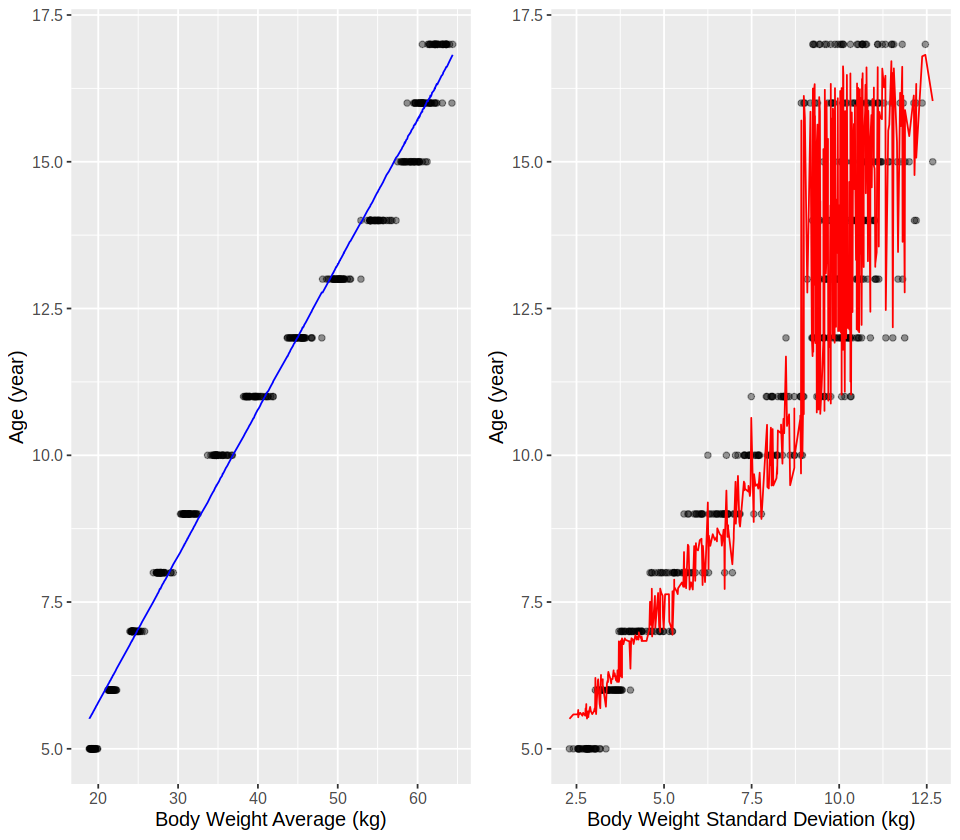

In [33]:
prediction_scatter_plots